In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#import tensorflow
import soundfile as sf
import matplotlib.pyplot as plt
import json
from scipy.fftpack import fft, fftfreq
import librosa
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import os
import pandas as pd

## Daten einlesen
siehe librosa_files

In [2]:
# determine path to `src/data`
cwd = os.getcwd()
src_dir = os.path.join(cwd, os.pardir)
data_dir = os.path.join(src_dir, 'data')

# get absolute paths for each file in `src/data`
data_file_paths = map(
    lambda file: os.path.join(data_dir, file),
    os.listdir(data_dir)
)
data_file_paths = list(data_file_paths)

In [3]:
feature_matrix = []
labels = []

max_iter = 25

for file in data_file_paths[:max_iter]:
    base = os.path.splitext(file)[0]
    extension = os.path.splitext(file)[1]
    
    if extension == '.flac' and os.path.isfile(base + '.csv'):
        label_file = pd.read_csv(base + '.csv')
        for index, row in label_file.iterrows():
            start = row['start']
            if start < 0: start = 0
            end = row['end']
            duration = end - start
            
            if duration <= 0:
                print(file)
                print(f'In row {index}')
                continue
            
            waveform, sample_rate = librosa.load(
                file,
                sr=None,    # do not resample file
                mono=True,
                offset=start,
                duration=duration)
            
            feature_matrix.append([fft(waveform), fftfreq(waveform.size, 1/sample_rate)])
            labels.append(-1 if (row['label'] == 'No_Whistle') else 1)

## 2D Plot

Die Daten werden durch zwei Bandfilter gefiltert. 2,5 - 3 Mhz wird auf die X-Achse und 2,5 - 3 Mhz auf die Y-Achse abgebildet

/home/johann/Dokumente/Studium/Master/2.Semester/Mustererkennung/24-mus-whistle/src/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/johann/Dokumente/Studium/Master/2.Semester/Mustererkennung/24-mus-whistle/src/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


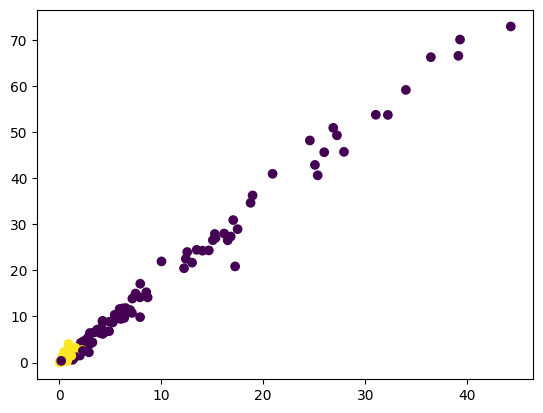

In [4]:
xs = []
ys = []
l = []
for feature, label in zip(feature_matrix, labels):
    filter_1 = np.average([np.abs(feature[0][x]) for x in np.where((feature[1] >= 20) & (feature[1] <= 25))])
    filter_2 = np.average([np.abs(feature[0][x]) for x in np.where((feature[1] >= 25) & (feature[1] <= 30))])
    
    if ~np.isnan(filter_1) and ~np.isnan(filter_2):
        xs.append(filter_1)
        ys.append(filter_2)
        l.append(label)

plt.scatter(xs,ys,c=l)
plt.show()

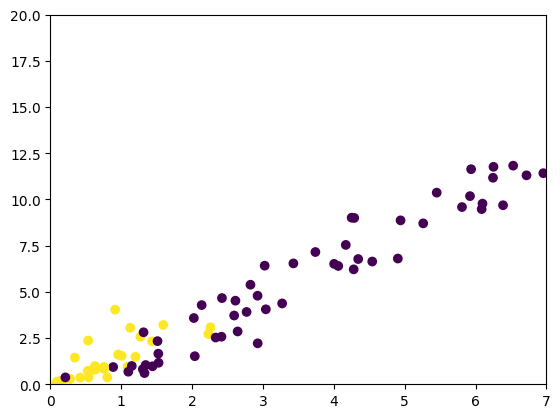

In [5]:
xs = []
ys = []
l = []
for feature, label in zip(feature_matrix, labels):
    filter_1 = np.average([np.abs(feature[0][x]) for x in np.where((feature[1] >= 20) & (feature[1] <= 25))])
    filter_2 = np.average([np.abs(feature[0][x]) for x in np.where((feature[1] >= 25) & (feature[1] <= 30))])
    
    if ~np.isnan(filter_1) and ~np.isnan(filter_2):
        xs.append(filter_1)
        ys.append(filter_2)
        l.append(label)

plt.scatter(xs,ys,c=l)
plt.xlim(0,7)
plt.ylim(0,20)
plt.show()

## 2D Perceptron

In [16]:
def learn(X, w, y, r) :
    predict = np.ravel(np.sign(X.dot(w.transpose())))
    errors = np.abs(1/2*(predict - y.transpose()))
    corection = X.T.dot(errors * -y)
    w = w - r * corection
    return w


def error(X, w, y) :
    predict = np.ravel(np.sign(X.dot(w.transpose())))
    errors = np.abs(1/2*(predict - y.transpose()))
    return 1 - np.sum(errors) / errors.shape

In [17]:
def fun(x, w):
    return w[0]/-w[2] + w[1]/-w[2] * x

In [18]:
xs = []
ys = []
l = []
for feature, label in zip(feature_matrix, labels):
    filter_1 = np.average([np.abs(feature[0][x]) for x in np.where((feature[1] >= 20) & (feature[1] <= 25))])
    filter_2 = np.average([np.abs(feature[0][x]) for x in np.where((feature[1] >= 25) & (feature[1] <= 30))])
    
    if ~np.isnan(filter_1) and ~np.isnan(filter_2):
        xs.append(filter_1)
        ys.append(filter_2)
        l.append(label)

p = np.vstack((np.ones(len(xs)), xs, ys)).T


In [19]:
w= np.array([1, 1, 1])

Accuracy: 0.9047619047619048


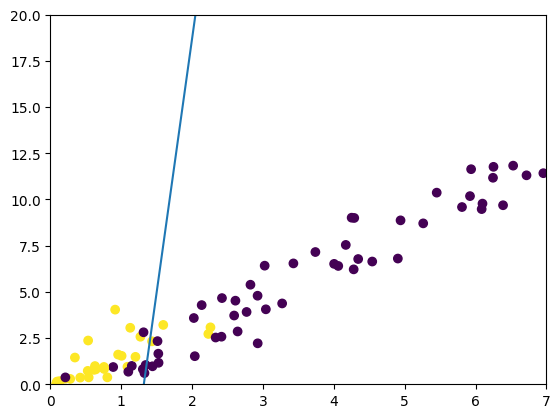

In [20]:
for i in range(100):
    w = learn(p, w, np.array(l).T, 0.025)
print(f"Accuracy: {error(p, w, np.array(l).T)[0]}")
plt.plot([0, 7],[fun(0, w), fun(7, w)])
plt.scatter(xs, ys, c=l)
plt.xlim(0,7)
plt.ylim(0,20)
plt.show()

In [27]:
botfreq = 18
topfreq = 30
stepwidth = 4
s = []
l = []
for feature, label in zip(feature_matrix, labels):
    filter = []
    is_nan = False
    for i in range(botfreq, topfreq, stepwidth):
        f = np.average([np.abs(feature[0][x]) for x in np.where((feature[1] >= i) & (feature[1] <= i+stepwidth))])
        if np.isnan(f):
            is_nan = True
            break
        filter.append(f)
    if is_nan == False:
        s.append(filter)
        l.append(label)
s = np.array(s)
p = np.vstack(([1] * s.shape[0], s.T)).T
print(l)

[-1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1]


In [28]:
w = np.ones(p.shape[1])

Accuracy: 0.9122807017543859
[ 1.3175  0.0456 -0.8542  0.0043]
[-1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1]


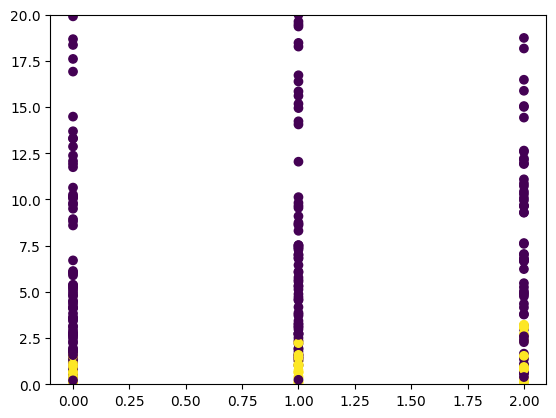

In [29]:
for i in range(100):
    w = learn(p, w, np.array(l).T, 0.0025)
print(f"Accuracy: {error(p, w, np.array(l).T)[0]}")
print(w)

print(l)
for i in range(0, s.shape[1]):
    plt.scatter(np.ones(s.T[i].shape) * i, s.T[i] , c=l)
plt.ylim(0,20)
plt.show()